In [1]:
import numpy as np
import torch
from transformers import AlbertTokenizerFast, AlbertModel, AutoModelForSequenceClassification, AutoTokenizer
from transformers import TrainingArguments, Trainer, EvalPrediction
from datasets import load_dataset, load_metric, Dataset
#from torch.utils.data import Dataset, DataLoader
import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataset = load_dataset('snli')
#tokenizer = AlbertTokenizerFast.from_pretrained('albert-base-v2')
#model = AutoModelForSequenceClassification.from_pretrained('albert-base-v2', num_labels=3)
max_length = 128
tokenizer = AutoTokenizer.from_pretrained('google/electra-small-discriminator', use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained('google/electra-small-discriminator', num_labels=3)


Found cached dataset snli (/home/brian/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b)


  0%|          | 0/3 [00:00<?, ?it/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
torch.cuda.is_available()

True

In [4]:
dataset

DatasetDict({
    test: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 550152
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label'],
        num_rows: 10000
    })
})

In [5]:
def compute_accuracy(eval_preds: EvalPrediction):
    return {
        'accuracy': (np.argmax(
            eval_preds.predictions,
            axis=1) == eval_preds.label_ids).astype(
            np.float32).mean().item()
    }

In [6]:
def tokenize_fn(example):
    return tokenizer(example['premise'], example['hypothesis'], truncation=True)
dataset_train = dataset.map(tokenize_fn, batched=True)


Loading cached processed dataset at /home/brian/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-91a90241f5f2eee7.arrow
Loading cached processed dataset at /home/brian/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-45990820c174b6e6.arrow
Loading cached processed dataset at /home/brian/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-f20f76a3850b7453.arrow


In [7]:
def abs_func(example):
    return {'label': example['label']} if example['label'] >= 0 else {'label':-example['label']}

dataset_train = dataset_train.map(abs_func, batched=False)

Loading cached processed dataset at /home/brian/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-60928df63213b5fd.arrow
Loading cached processed dataset at /home/brian/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-411a49af097d03b6.arrow
Loading cached processed dataset at /home/brian/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b/cache-cc16e5ba8b5b5932.arrow


In [8]:
def create_map_data(data:pd.DataFrame, model) -> pd.DataFrame:
    #df = pd.DataFrame([], columns=['premise','hypothesis', 'label','e0', 'e1', 'e2', 'e3', 'e4', 'confidence', 'variability'])
    dict_data = {'premise':[], 'hypothesis':[], 'label':[], 'e':[], 'confidence':[], 'variability':[], 'corr_frac': [], 'input_ids':[], 'token_type_ids':[], 'attention_mask':[]}
    for sample in tqdm.notebook.tqdm(data):
        dict_data['premise'].append(sample['premise'])
        dict_data['hypothesis'].append(sample['hypothesis'])
        #dict_data['model_input'].append(tokenizer(sample['premise'], sample['hypothesis'], return_tensors='pt', truncation=True, padding=True))
        dict_data['label'].append(sample['label'])
        dict_data['e'].append([])
        dict_data['confidence'].append(0.)
        dict_data['variability'].append(0.)
        dict_data['corr_frac'].append([])
        dict_data['input_ids'].append(sample['input_ids'])
        dict_data['token_type_ids'].append(sample['token_type_ids'])
        dict_data['attention_mask'].append(sample['attention_mask'])
        #df.loc[-1] = [sample['premise'], sample['hypothesis'], sample['label'], 0., 0., 0., 0., 0., 0., 0.]
        #df.index += 1
        #df = df.sort_index()
            
    df = pd.DataFrame.from_dict(dict_data)
    return df

In [9]:
def train_model(model, tokenizer, dataset_train, epochs = 1):

    #tokenizer = AlbertTokenizerFast.from_pretrained('albert-base-v2')
    #model = AutoModelForSequenceClassification.from_pretrained('albert-base-v2', num_labels=3)

    training_args = TrainingArguments(
        output_dir="output", 
        evaluation_strategy="steps", 
        num_train_epochs = epochs,
        warmup_steps = 1000,
        logging_steps = 2000,
        save_steps = 2000,
        load_best_model_at_end = True,
        learning_rate = 5e-5,
        per_device_train_batch_size=64
        )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset_train['train'],
        eval_dataset=dataset_train['validation'],
        tokenizer=tokenizer,
        compute_metrics=compute_accuracy

    )
    trainer.train()

In [10]:
tokenizer = AutoTokenizer.from_pretrained('google/electra-small-discriminator', use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained('google/electra-small-discriminator', num_labels=3)
model.to('cuda')

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Li

In [11]:
"""
@inproceedings{swayamdipta2020dataset,
    title={Dataset Cartography: Mapping and Diagnosing Datasets with Training Dynamics},
    author={Swabha Swayamdipta and Roy Schwartz and Nicholas Lourie and Yizhong Wang and Hannaneh Hajishirzi and Noah A. Smith and Yejin Choi},
    booktitle={Proceedings of EMNLP},
    url={https://arxiv.org/abs/2009.10795},
    year={2020}
}
"""

def scatter_it(dataframe, hue_metric ='corr_frac', title='', model = 'electra', show_hist=False):
    import seaborn as sns
    # Subsample data to plot, so the plot is not too busy.
    dataframe = dataframe.sample(n=25000 if dataframe.shape[0] > 25000 else len(dataframe))
    
    # Normalize correctness to a value between 0 and 1.
    dataframe = dataframe.assign(corr_frac = lambda d: d.corr_frac / d.corr_frac.max())
    dataframe['corr_frac'] = [f"{x:.1f}" for x in dataframe['corr_frac']]
    
    main_metric = 'variability'
    other_metric = 'confidence'
    
    hue = hue_metric
    num_hues = len(dataframe[hue].unique().tolist())
    style = hue_metric if num_hues < 8 else None

    if not show_hist:
        fig, axs = plt.subplots(1, 1, figsize=(8, 4))
        ax0 = axs
    else:
        fig = plt.figure(figsize=(16, 10), )
        gs = fig.add_gridspec(2, 3, height_ratios=[5, 1])
    
        ax0 = fig.add_subplot(gs[0, :])
    
    
    ### Make the scatterplot.
    
    # Choose a palette.
    pal = sns.diverging_palette(260, 15, n=num_hues, sep=10, center="dark")

    plot = sns.scatterplot(x=main_metric,
                           y=other_metric,
                           ax=ax0,
                           data=dataframe,
                           hue=hue,
                           palette=pal,
                           style=style,
                           s=30)
    
    # Annotate Regions.
    bb = lambda c: dict(boxstyle="round,pad=0.3", ec=c, lw=2, fc="white")
    an1 = ax0.annotate("ambiguous", xy=(0.9, 0.5), xycoords="axes fraction", fontsize=15, color='black',
                  va="center", ha="center", rotation=350, bbox=bb('black'))
    an2 = ax0.annotate("easy-to-learn", xy=(0.27, 0.85), xycoords="axes fraction", fontsize=15, color='black',
                  va="center", ha="center", bbox=bb('r'))
    an3 = ax0.annotate("hard-to-learn", xy=(0.35, 0.25), xycoords="axes fraction", fontsize=15, color='black',
                  va="center", ha="center", bbox=bb('b'))
    
    if not show_hist:
        plot.legend(ncol=1, bbox_to_anchor=(1.01, 0.5), loc='center left', fancybox=True, shadow=True)
    else:
        plot.legend(fancybox=True, shadow=True,  ncol=1)
    plot.set_xlabel('variability')
    plot.set_ylabel('confidence')
    
    if show_hist:
        plot.set_title(f"{model}-{title} Data Map", fontsize=17)
        
        # Make the histograms.
        ax1 = fig.add_subplot(gs[1, 0])
        ax2 = fig.add_subplot(gs[1, 1])
        ax3 = fig.add_subplot(gs[1, 2])

        plott0 = dataframe.hist(column=['confidence'], ax=ax1, color='#622a87')
        plott0[0].set_title('')
        plott0[0].set_xlabel('confidence')
        plott0[0].set_ylabel('density')

        plott1 = dataframe.hist(column=['variability'], ax=ax2, color='teal')
        plott1[0].set_title('')
        plott1[0].set_xlabel('variability')

        plot2 = sns.countplot(x="corr_frac", data=dataframe, color='#86bf91', ax=ax3)
        ax3.xaxis.grid(True) # Show the vertical gridlines

        plot2.set_title('')
        plot2.set_xlabel('correctness')
        plot2.set_ylabel('')

    fig.tight_layout()
    filename = f'figures/{title}_{model}.pdf' if show_hist else f'figures/compact_{title}_{model}.pdf'
    fig.savefig(filename, dpi=300)


In [29]:
def create_map(dataset: pd.DataFrame, model = None, epochs = 2):
    if model == None:
        tokenizer = AutoTokenizer.from_pretrained('google/electra-small-discriminator', use_fast=True)
        model = AutoModelForSequenceClassification.from_pretrained('google/electra-small-discriminator', num_labels=3)
        model.to('cuda')
    

    print('generating data')
    mapped_data = create_map_data(dataset, model)
    
    training_args = TrainingArguments(
        output_dir="output", 
        evaluation_strategy="epoch", 
        save_strategy = 'epoch',
        num_train_epochs = 1,
        load_best_model_at_end = True,
        learning_rate = 5e-5,
        per_device_train_batch_size=128
        )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=dataset,
        eval_dataset=dataset_train['validation'],
        tokenizer=tokenizer,
        compute_metrics=compute_accuracy

    )

    data_dict = mapped_data.to_dict()
    
    for e in tqdm.notebook.tqdm(range(epochs)):
        model.to('cuda')
        print(f'training: {e}')
        trainer.train()
        print(f'recording: {e}')


        for i in tqdm.notebook.tqdm(range(len(mapped_data))):
            x = torch.softmax(model(**tokenizer(data_dict['premise'][i], data_dict['hypothesis'][i], return_tensors='pt', truncation=True, padding=True).to('cuda')).logits[0], dim=-1)    
            #x = torch.softmax(model(**data_dict['model_input'][i].to('cuda')).logits[0], dim=-1)
            data_dict['corr_frac'][i].append(1 if torch.argmax(x) == data_dict['label'][i] else 0)
            data_dict['e'][i].append(round(x[data_dict['label'][i]].to('cpu').item(), 4))



    print(f'calculating confidence and variability')
    
    for i in tqdm.notebook.tqdm(range(len(mapped_data))):
        data_dict['confidence'][i] = np.average(data_dict['e'][i])
        data_dict['variability'][i] = np.sqrt(np.average([(data_dict['e'][i] - data_dict['confidence'][i])**2]))
        data_dict['corr_frac'][i] = np.average(data_dict['corr_frac'][i])

    mapped_data = pd.DataFrame.from_dict(data_dict)

    return mapped_data, model




In [30]:
map_snli, model = create_map(dataset_train['train'], epochs=3)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generating data


  0%|          | 0/550152 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

training: 0


  0%|          | 0/4299 [00:00<?, ?it/s]

You're using a ElectraTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.6806, 'learning_rate': 4.418469411491045e-05, 'epoch': 0.12}
{'loss': 0.5006, 'learning_rate': 3.836938822982089e-05, 'epoch': 0.23}
{'loss': 0.474, 'learning_rate': 3.2554082344731335e-05, 'epoch': 0.35}
{'loss': 0.4413, 'learning_rate': 2.6738776459641778e-05, 'epoch': 0.47}
{'loss': 0.4293, 'learning_rate': 2.0923470574552225e-05, 'epoch': 0.58}
{'loss': 0.4193, 'learning_rate': 1.5108164689462668e-05, 'epoch': 0.7}
{'loss': 0.4131, 'learning_rate': 9.29285880437311e-06, 'epoch': 0.81}
{'loss': 0.4077, 'learning_rate': 3.477552919283555e-06, 'epoch': 0.93}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.35564500093460083, 'eval_accuracy': 0.868399977684021, 'eval_runtime': 8.8055, 'eval_samples_per_second': 1135.65, 'eval_steps_per_second': 141.956, 'epoch': 1.0}
{'train_runtime': 325.6648, 'train_samples_per_second': 1689.32, 'train_steps_per_second': 13.201, 'train_loss': 0.4657976709983881, 'epoch': 1.0}
recording: 0


  0%|          | 0/550152 [00:00<?, ?it/s]

training: 1


  0%|          | 0/4299 [00:00<?, ?it/s]

{'loss': 0.4014, 'learning_rate': 4.418469411491045e-05, 'epoch': 0.12}
{'loss': 0.3956, 'learning_rate': 3.836938822982089e-05, 'epoch': 0.23}
{'loss': 0.3879, 'learning_rate': 3.2554082344731335e-05, 'epoch': 0.35}
{'loss': 0.3825, 'learning_rate': 2.6738776459641778e-05, 'epoch': 0.47}
{'loss': 0.3799, 'learning_rate': 2.0923470574552225e-05, 'epoch': 0.58}
{'loss': 0.3696, 'learning_rate': 1.5108164689462668e-05, 'epoch': 0.7}
{'loss': 0.3642, 'learning_rate': 9.29285880437311e-06, 'epoch': 0.81}
{'loss': 0.3554, 'learning_rate': 3.477552919283555e-06, 'epoch': 0.93}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.32272467017173767, 'eval_accuracy': 0.8809999823570251, 'eval_runtime': 8.6648, 'eval_samples_per_second': 1154.094, 'eval_steps_per_second': 144.262, 'epoch': 1.0}
{'train_runtime': 330.3006, 'train_samples_per_second': 1665.61, 'train_steps_per_second': 13.015, 'train_loss': 0.37824025834042074, 'epoch': 1.0}
recording: 1


  0%|          | 0/550152 [00:00<?, ?it/s]

training: 2


  0%|          | 0/4299 [00:00<?, ?it/s]

{'loss': 0.3533, 'learning_rate': 4.418469411491045e-05, 'epoch': 0.12}
{'loss': 0.3536, 'learning_rate': 3.836938822982089e-05, 'epoch': 0.23}
{'loss': 0.3536, 'learning_rate': 3.2554082344731335e-05, 'epoch': 0.35}
{'loss': 0.3495, 'learning_rate': 2.6738776459641778e-05, 'epoch': 0.47}
{'loss': 0.3418, 'learning_rate': 2.0923470574552225e-05, 'epoch': 0.58}
{'loss': 0.3392, 'learning_rate': 1.5108164689462668e-05, 'epoch': 0.7}
{'loss': 0.3355, 'learning_rate': 9.29285880437311e-06, 'epoch': 0.81}
{'loss': 0.3303, 'learning_rate': 3.477552919283555e-06, 'epoch': 0.93}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.31316035985946655, 'eval_accuracy': 0.8848999738693237, 'eval_runtime': 8.4159, 'eval_samples_per_second': 1188.231, 'eval_steps_per_second': 148.529, 'epoch': 1.0}
{'train_runtime': 324.8101, 'train_samples_per_second': 1693.765, 'train_steps_per_second': 13.235, 'train_loss': 0.3438977199145377, 'epoch': 1.0}
recording: 2


  0%|          | 0/550152 [00:00<?, ?it/s]

calculating confidence and variability


  0%|          | 0/550152 [00:00<?, ?it/s]

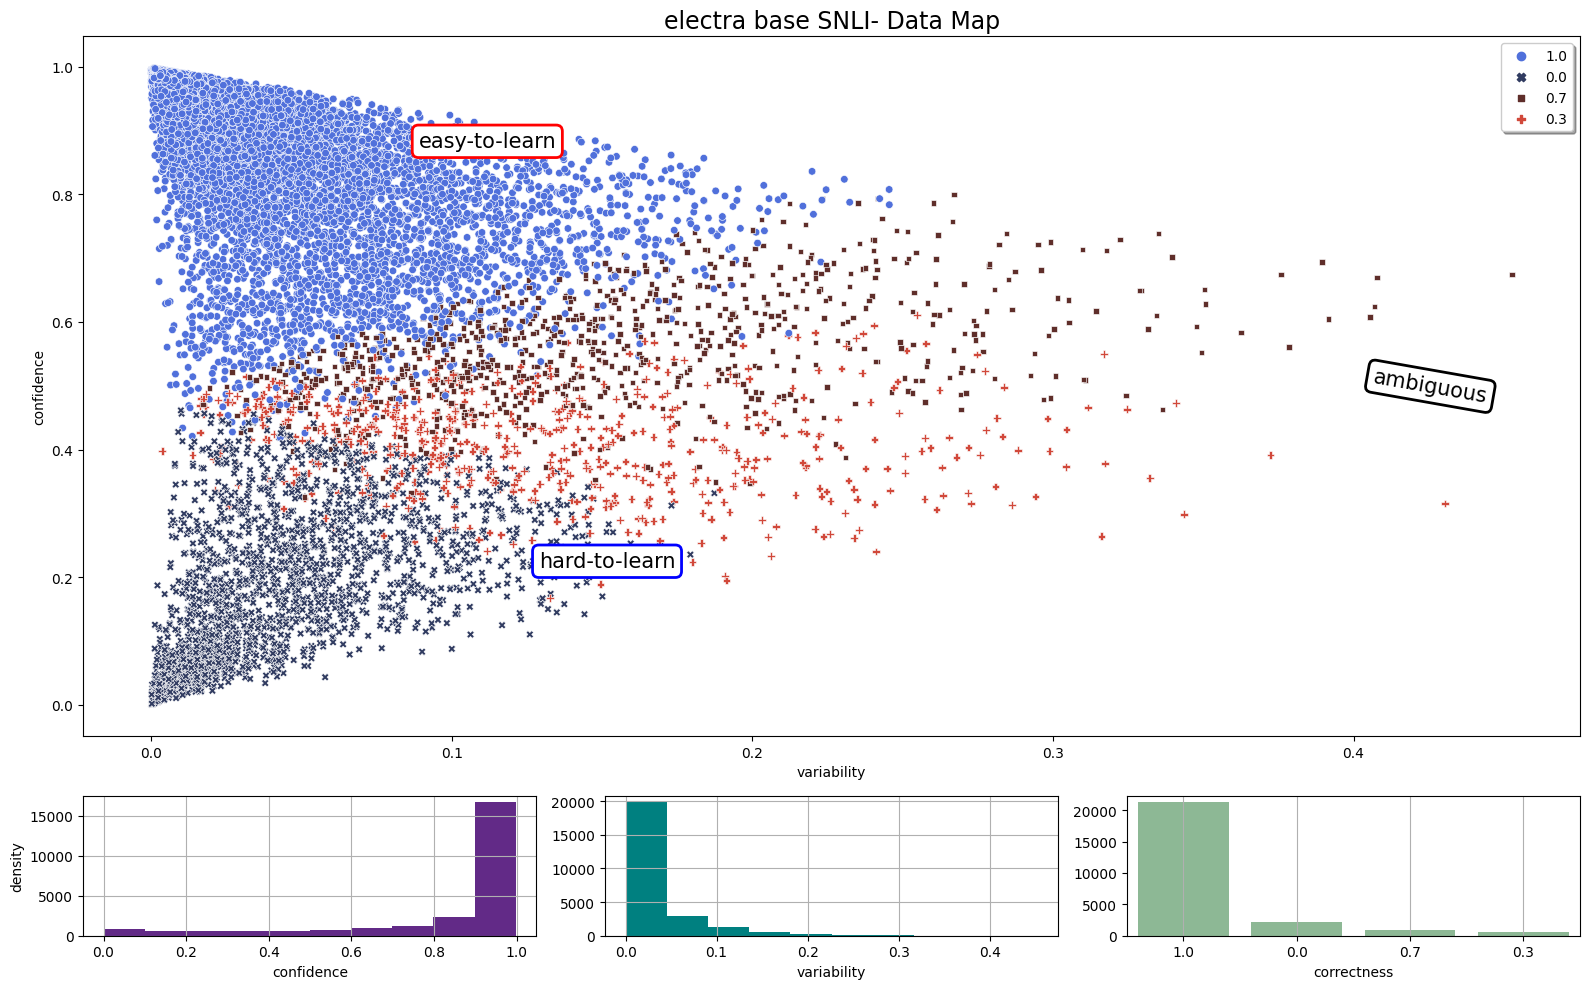

In [31]:
scatter_it(map_snli, show_hist=True, model='electra base SNLI')

In [32]:
model.save_pretrained('full_trained')

In [33]:
"""
for whole dataset
    confidence < 0.5
    variability > 0.35

for partial dataset
    confidence < 0.4
    variability > 0.25
"""

hard_data = {'premise':[], 'hypothesis':[], 'label':[], 'e':[], 'confidence':[], 'variability':[], 'corr_frac': []}
hard_train = {'premise':[], 'hypothesis':[], 'label':[], 'input_ids':[], 'token_type_ids':[], 'attention_mask':[]}

data_dict = map_snli.to_dict()

for i in range(len(map_snli)):
    if data_dict['confidence'][i] < 0.5 or data_dict['variability'][i] > 0.35 or data_dict['corr_frac'][i] < 0.6:
        hard_data['premise'].append(data_dict['premise'][i])
        hard_data['hypothesis'].append(data_dict['hypothesis'][i])
        hard_data['label'].append(data_dict['label'][i])
        hard_data['e'].append([])
        hard_data['confidence'].append(0.)
        hard_data['variability'].append(0.)
        hard_data['corr_frac'].append([])


        hard_train['premise'].append(data_dict['premise'][i])
        hard_train['hypothesis'].append(data_dict['hypothesis'][i])
        hard_train['label'].append(data_dict['label'][i])
        hard_train['input_ids'].append(data_dict['input_ids'][i])
        hard_train['token_type_ids'].append(data_dict['token_type_ids'][i])
        hard_train['attention_mask'].append(data_dict['attention_mask'][i])
        
    hard_data['premise'].append(data_dict['premise'][i])
    hard_data['hypothesis'].append(data_dict['hypothesis'][i])
    hard_data['label'].append(data_dict['label'][i])
    hard_data['e'].append([])
    hard_data['confidence'].append(0.)
    hard_data['variability'].append(0.)
    hard_data['corr_frac'].append([])


    hard_train['premise'].append(data_dict['premise'][i])
    hard_train['hypothesis'].append(data_dict['hypothesis'][i])
    hard_train['label'].append(data_dict['label'][i])
    hard_train['input_ids'].append(data_dict['input_ids'][i])
    hard_train['token_type_ids'].append(data_dict['token_type_ids'][i])
    hard_train['attention_mask'].append(data_dict['attention_mask'][i])


hard_data = pd.DataFrame.from_dict(hard_data)
hard_train = pd.DataFrame.from_dict(hard_train)
hard_data


,premise,hypothesis,label,e,confidence,variability,corr_frac
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,1,[],0.0,0.0,[]
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",2,[],0.0,0.0,[]
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",0,[],0.0,0.0,[]
3,Children smiling and waving at camera,They are smiling at their parents,1,[],0.0,0.0,[]
4,Children smiling and waving at camera,There are children present,0,[],0.0,0.0,[]
...,...,...,...,...,...,...,...
616900,Four dirty and barefooted children.,four kids won awards for 'cleanest feet',2,[],0.0,0.0,[]
616901,Four dirty and barefooted children.,"four homeless children had their shoes stolen,...",1,[],0.0,0.0,[]
616902,A man is surfing in a bodysuit in beautiful bl...,A man in a bodysuit is competing in a surfing ...,1,[],0.0,0.0,[]
616903,A man is surfing in a bodysuit in beautiful bl...,A man in a business suit is heading to a board...,2,[],0.0,0.0,[]


In [34]:
hard_train

,premise,hypothesis,label,input_ids,token_type_ids,attention_mask
0,A person on a horse jumps over a broken down a...,A person is training his horse for a competition.,1,"[101, 1037, 2711, 2006, 1037, 3586, 14523, 205...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,A person on a horse jumps over a broken down a...,"A person is at a diner, ordering an omelette.",2,"[101, 1037, 2711, 2006, 1037, 3586, 14523, 205...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,A person on a horse jumps over a broken down a...,"A person is outdoors, on a horse.",0,"[101, 1037, 2711, 2006, 1037, 3586, 14523, 205...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,Children smiling and waving at camera,They are smiling at their parents,1,"[101, 2336, 5629, 1998, 12015, 2012, 4950, 102...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
4,Children smiling and waving at camera,There are children present,0,"[101, 2336, 5629, 1998, 12015, 2012, 4950, 102...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
...,...,...,...,...,...,...
616900,Four dirty and barefooted children.,four kids won awards for 'cleanest feet',2,"[101, 2176, 6530, 1998, 22985, 2098, 2336, 101...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
616901,Four dirty and barefooted children.,"four homeless children had their shoes stolen,...",1,"[101, 2176, 6530, 1998, 22985, 2098, 2336, 101...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
616902,A man is surfing in a bodysuit in beautiful bl...,A man in a bodysuit is competing in a surfing ...,1,"[101, 1037, 2158, 2003, 19967, 1999, 1037, 230...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
616903,A man is surfing in a bodysuit in beautiful bl...,A man in a business suit is heading to a board...,2,"[101, 1037, 2158, 2003, 19967, 1999, 1037, 230...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [35]:
hard_train = Dataset.from_pandas(hard_train)

In [36]:
dataset_train['validation']

Dataset({
    features: ['premise', 'hypothesis', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 10000
})

In [37]:
only_hard_data = {'premise':[], 'hypothesis':[], 'label':[], 'e':[], 'confidence':[], 'variability':[], 'corr_frac': []}
only_hard_train = {'premise':[], 'hypothesis':[], 'label':[], 'input_ids':[], 'token_type_ids':[], 'attention_mask':[]}

data_dict = map_snli.to_dict()

for i in range(len(map_snli)):
    if data_dict['confidence'][i] < 0.5 or data_dict['variability'][i] > 0.35 or data_dict['corr_frac'][i] < 0.6:
        only_hard_data['premise'].append(data_dict['premise'][i])
        only_hard_data['hypothesis'].append(data_dict['hypothesis'][i])
        only_hard_data['label'].append(data_dict['label'][i])
        only_hard_data['e'].append([])
        only_hard_data['confidence'].append(0.)
        only_hard_data['variability'].append(0.)
        only_hard_data['corr_frac'].append([])


        only_hard_train['premise'].append(data_dict['premise'][i])
        only_hard_train['hypothesis'].append(data_dict['hypothesis'][i])
        only_hard_train['label'].append(data_dict['label'][i])
        only_hard_train['input_ids'].append(data_dict['input_ids'][i])
        only_hard_train['token_type_ids'].append(data_dict['token_type_ids'][i])
        only_hard_train['attention_mask'].append(data_dict['attention_mask'][i])
        
map_snli = pd.DataFrame.from_dict(data_dict)

only_hard_data = pd.DataFrame.from_dict(only_hard_data)
only_hard_train = pd.DataFrame.from_dict(only_hard_train)
only_hard_train = Dataset.from_pandas(only_hard_train)
only_hard_train


Dataset({
    features: ['premise', 'hypothesis', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 66753
})

In [54]:
D = only_hard_data.to_dict()['label']
np.unique([D[i] for i in range(len(only_hard_data))], return_counts=True)

(array([0, 1, 2]), array([17966, 31309, 17478]))

In [55]:
def eval(model, data):
    training_args = TrainingArguments(
        output_dir="output", 
        evaluation_strategy="steps", 
        num_train_epochs = 1,
        warmup_steps = 1000,
        logging_steps = 200,
        save_steps = 200,
        load_best_model_at_end = True,
        learning_rate = 5e-5,
        per_device_train_batch_size=64
        )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=data,
        eval_dataset=data,
        tokenizer=tokenizer,
        compute_metrics=compute_accuracy

    )
    return trainer.evaluate(data)

In [56]:
print(eval(model, hard_train))
print(eval(model, dataset_train['test']))

  0%|          | 0/77114 [00:00<?, ?it/s]

{'eval_loss': 0.4296475052833557, 'eval_accuracy': 0.8267123699188232, 'eval_runtime': 505.2357, 'eval_samples_per_second': 1221.024, 'eval_steps_per_second': 152.63}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.32780835032463074, 'eval_accuracy': 0.8809000253677368, 'eval_runtime': 8.2136, 'eval_samples_per_second': 1217.497, 'eval_steps_per_second': 152.187}


In [57]:
def prediction_model(model, a, b = '', tensor = False):
    model.to('cpu')
    x1 = model(**tokenizer(a, b, return_tensors='pt', truncation=True, padding=True)).logits[0]
    if tensor: return torch.softmax(x1, dim=-1)
    return [l.item() for l in torch.softmax(x1, dim=-1)]

In [63]:
def train_n_test(train:Dataset, epochs=1):
    model = AutoModelForSequenceClassification.from_pretrained('full_trained')
    model.to('cuda')
   
    training_args = TrainingArguments(
        output_dir="output", 
        evaluation_strategy="epoch", 
        save_strategy = 'epoch',
        num_train_epochs = epochs,
        load_best_model_at_end = True,
        learning_rate = 5e-5,
        per_device_train_batch_size=128
        )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train,
        eval_dataset=dataset_train['validation'],
        tokenizer=tokenizer,
        compute_metrics=compute_accuracy

    )
    trainer.train()
    print(trainer.evaluate(dataset_train['test']))
    print(trainer.evaluate(only_hard_train))
    print(prediction_model(model, "The food needs to be eaten soon.", "The food will expire fast."))
    print(prediction_model(model, "A man with a cane walks away from a food cart.", "The cane helps the man walk better."))
    print(prediction_model(model, "Two men are in a room with four visible beds.", "Two men showing their bedroom to photographer."))


In [59]:
train_n_test(dataset_train['train'])

  0%|          | 0/4299 [00:00<?, ?it/s]

{'loss': 0.3158, 'learning_rate': 4.418469411491045e-05, 'epoch': 0.12}
{'loss': 0.2976, 'learning_rate': 3.836938822982089e-05, 'epoch': 0.23}
{'loss': 0.3022, 'learning_rate': 3.2554082344731335e-05, 'epoch': 0.35}
{'loss': 0.2892, 'learning_rate': 2.6738776459641778e-05, 'epoch': 0.47}
{'loss': 0.2957, 'learning_rate': 2.0923470574552225e-05, 'epoch': 0.58}
{'loss': 0.2984, 'learning_rate': 1.5108164689462668e-05, 'epoch': 0.7}
{'loss': 0.3051, 'learning_rate': 9.29285880437311e-06, 'epoch': 0.81}
{'loss': 0.3102, 'learning_rate': 3.477552919283555e-06, 'epoch': 0.93}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.3158491253852844, 'eval_accuracy': 0.8901000022888184, 'eval_runtime': 8.3237, 'eval_samples_per_second': 1201.395, 'eval_steps_per_second': 150.174, 'epoch': 1.0}
{'train_runtime': 328.754, 'train_samples_per_second': 1673.446, 'train_steps_per_second': 13.077, 'train_loss': 0.3023507383763166, 'epoch': 1.0}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.33022066950798035, 'eval_accuracy': 0.8830999732017517, 'eval_runtime': 8.292, 'eval_samples_per_second': 1205.979, 'eval_steps_per_second': 150.747, 'epoch': 1.0}


  0%|          | 0/77114 [00:00<?, ?it/s]

{'eval_loss': 0.390756219625473, 'eval_accuracy': 0.8462210297584534, 'eval_runtime': 510.376, 'eval_samples_per_second': 1208.726, 'eval_steps_per_second': 151.093, 'epoch': 1.0}


  0%|          | 0/8345 [00:00<?, ?it/s]

{'eval_loss': 1.570905327796936, 'eval_accuracy': 0.30818089842796326, 'eval_runtime': 55.7515, 'eval_samples_per_second': 1197.33, 'eval_steps_per_second': 149.682, 'epoch': 1.0}
[0.26384755969047546, 0.3505949378013611, 0.38555747270584106]
[0.3583790957927704, 0.5643786787986755, 0.07724221795797348]
[0.025930676609277725, 0.9647358655929565, 0.009333549998700619]


In [60]:
train_n_test(hard_train)

  0%|          | 0/4820 [00:00<?, ?it/s]

{'loss': 0.4524, 'learning_rate': 4.481327800829876e-05, 'epoch': 0.1}
{'loss': 0.4475, 'learning_rate': 3.962655601659751e-05, 'epoch': 0.21}
{'loss': 0.4428, 'learning_rate': 3.4439834024896265e-05, 'epoch': 0.31}
{'loss': 0.4441, 'learning_rate': 2.9253112033195024e-05, 'epoch': 0.41}
{'loss': 0.4358, 'learning_rate': 2.406639004149378e-05, 'epoch': 0.52}
{'loss': 0.4317, 'learning_rate': 1.887966804979253e-05, 'epoch': 0.62}
{'loss': 0.4258, 'learning_rate': 1.3692946058091288e-05, 'epoch': 0.73}
{'loss': 0.4172, 'learning_rate': 8.506224066390042e-06, 'epoch': 0.83}
{'loss': 0.421, 'learning_rate': 3.319502074688797e-06, 'epoch': 0.93}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.3079988658428192, 'eval_accuracy': 0.8899999856948853, 'eval_runtime': 8.4525, 'eval_samples_per_second': 1183.078, 'eval_steps_per_second': 147.885, 'epoch': 1.0}
{'train_runtime': 369.7751, 'train_samples_per_second': 1668.325, 'train_steps_per_second': 13.035, 'train_loss': 0.43418410368480126, 'epoch': 1.0}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.3230985701084137, 'eval_accuracy': 0.8842999935150146, 'eval_runtime': 8.4402, 'eval_samples_per_second': 1184.804, 'eval_steps_per_second': 148.1, 'epoch': 1.0}


  0%|          | 0/77114 [00:00<?, ?it/s]

{'eval_loss': 0.3426428437232971, 'eval_accuracy': 0.8600092530250549, 'eval_runtime': 524.7762, 'eval_samples_per_second': 1175.558, 'eval_steps_per_second': 146.946, 'epoch': 1.0}


  0%|          | 0/8345 [00:00<?, ?it/s]

{'eval_loss': 1.2177826166152954, 'eval_accuracy': 0.3916378319263458, 'eval_runtime': 56.9382, 'eval_samples_per_second': 1172.377, 'eval_steps_per_second': 146.562, 'epoch': 1.0}
[0.4539842903614044, 0.2862755358219147, 0.2597401440143585]
[0.5114043951034546, 0.42332494258880615, 0.06527058035135269]
[0.11877395212650299, 0.8665379285812378, 0.014688174240291119]


In [61]:
train_n_test(only_hard_train)

  0%|          | 0/522 [00:00<?, ?it/s]

{'loss': 0.9271, 'learning_rate': 2.1072796934865904e-06, 'epoch': 0.96}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 1.7207974195480347, 'eval_accuracy': 0.13040000200271606, 'eval_runtime': 8.6673, 'eval_samples_per_second': 1153.766, 'eval_steps_per_second': 144.221, 'epoch': 1.0}
{'train_runtime': 48.4668, 'train_samples_per_second': 1377.293, 'train_steps_per_second': 10.77, 'train_loss': 0.923876857392176, 'epoch': 1.0}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 1.7244365215301514, 'eval_accuracy': 0.13220000267028809, 'eval_runtime': 8.7516, 'eval_samples_per_second': 1142.645, 'eval_steps_per_second': 142.831, 'epoch': 1.0}


  0%|          | 0/77114 [00:00<?, ?it/s]

{'eval_loss': 1.6187175512313843, 'eval_accuracy': 0.18561042845249176, 'eval_runtime': 522.7113, 'eval_samples_per_second': 1180.202, 'eval_steps_per_second': 147.527, 'epoch': 1.0}


  0%|          | 0/8345 [00:00<?, ?it/s]

{'eval_loss': 0.7880203127861023, 'eval_accuracy': 0.6232828497886658, 'eval_runtime': 57.3737, 'eval_samples_per_second': 1163.477, 'eval_steps_per_second': 145.45, 'epoch': 1.0}
[0.2722174823284149, 0.3022831678390503, 0.42549929022789]
[0.6680379509925842, 0.1493731290102005, 0.1825888752937317]
[0.6215929388999939, 0.1656579226255417, 0.21274910867214203]


In [65]:
train_n_test(only_hard_train, epochs=2)

  0%|          | 0/1044 [00:00<?, ?it/s]

{'loss': 0.9098, 'learning_rate': 2.6053639846743293e-05, 'epoch': 0.96}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 2.3527629375457764, 'eval_accuracy': 0.11270000040531158, 'eval_runtime': 8.5158, 'eval_samples_per_second': 1174.29, 'eval_steps_per_second': 146.786, 'epoch': 1.0}
{'loss': 0.7475, 'learning_rate': 2.1072796934865904e-06, 'epoch': 1.92}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 2.8846893310546875, 'eval_accuracy': 0.1137000024318695, 'eval_runtime': 8.576, 'eval_samples_per_second': 1166.039, 'eval_steps_per_second': 145.755, 'epoch': 2.0}
{'train_runtime': 99.142, 'train_samples_per_second': 1346.614, 'train_steps_per_second': 10.53, 'train_loss': 0.8246260858586921, 'epoch': 2.0}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 2.3478565216064453, 'eval_accuracy': 0.11509999632835388, 'eval_runtime': 8.5312, 'eval_samples_per_second': 1172.163, 'eval_steps_per_second': 146.52, 'epoch': 2.0}


  0%|          | 0/8345 [00:00<?, ?it/s]

{'eval_loss': 0.7121946811676025, 'eval_accuracy': 0.6663071513175964, 'eval_runtime': 56.5927, 'eval_samples_per_second': 1179.533, 'eval_steps_per_second': 147.457, 'epoch': 2.0}
[0.30569568276405334, 0.2762356400489807, 0.41806867718696594]
[0.8849315643310547, 0.044670797884464264, 0.07039758563041687]
[0.7759432792663574, 0.05078665912151337, 0.1732700616121292]


In [64]:
print(eval(model, only_hard_train))

  0%|          | 0/8345 [00:00<?, ?it/s]

{'eval_loss': 1.719179630279541, 'eval_accuracy': 0.21199047565460205, 'eval_runtime': 56.2466, 'eval_samples_per_second': 1186.793, 'eval_steps_per_second': 148.365}


In [54]:
def extended_train(train_data:Dataset, dataset: pd.DataFrame = 'None', model = 'trained', epochs = 2):

    model = AutoModelForSequenceClassification.from_pretrained(model)
    model.to('cuda')

    if type(dataset) == str:
        print('generating data')
        dataset = create_map_data(train_data, model)
    
    training_args = TrainingArguments(
        output_dir="output", 
        evaluation_strategy="steps", 
        num_train_epochs = 1,
        logging_steps = 100000,
        save_steps = 100000,
        load_best_model_at_end = True,
        learning_rate = 5e-5,
        per_device_train_batch_size=128
        )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_data,
        eval_dataset=train_data,
        tokenizer=tokenizer,
        compute_metrics=compute_accuracy

    )

    data_dict = dataset.to_dict()
    
    for e in tqdm.notebook.tqdm(range(epochs)):
        print(f'training: {e}')
        trainer.train()
        print(f'recording: {e}')


        for i in tqdm.notebook.tqdm(range(len(dataset))):
            x = torch.softmax(model(**tokenizer(data_dict['premise'][i], data_dict['hypothesis'][i], return_tensors='pt', truncation=True, padding=True).to('cuda')).logits[0], dim=-1)    
            #x = torch.softmax(model(**data_dict['model_input'][i].to('cuda')).logits[0], dim=-1)
            data_dict['corr_frac'][i].append(1 if torch.argmax(x) == data_dict['label'][i] else 0)
            data_dict['e'][i].append(x[data_dict['label'][i]].to('cpu').item())



    print(f'calculating confidence and variability')
    
    for i in tqdm.notebook.tqdm(range(len(dataset))):
        data_dict['confidence'][i] = np.average(data_dict['e'][i])
        data_dict['variability'][i] = np.sqrt(np.average([(data_dict['e'][i] - data_dict['confidence'][i])**2]))
        data_dict['corr_frac'][i] = np.average(data_dict['corr_frac'][i])

    mapped_data = pd.DataFrame.from_dict(data_dict)

    return mapped_data, model

In [22]:
snli2, model_hard = extended_train(hard_train, hard_data, epochs=2)


  0%|          | 0/2 [00:00<?, ?it/s]

training: 0


  0%|          | 0/5056 [00:00<?, ?it/s]

{'train_runtime': 372.3707, 'train_samples_per_second': 1737.873, 'train_steps_per_second': 13.578, 'train_loss': 0.5787768303593502, 'epoch': 1.0}
recording: 0


  0%|          | 0/647133 [00:00<?, ?it/s]

training: 1


  0%|          | 0/5056 [00:00<?, ?it/s]

{'train_runtime': 370.3096, 'train_samples_per_second': 1747.546, 'train_steps_per_second': 13.653, 'train_loss': 0.4885824179347557, 'epoch': 1.0}
recording: 1


  0%|          | 0/647133 [00:00<?, ?it/s]

calculating confidence and variability


  0%|          | 0/647133 [00:00<?, ?it/s]

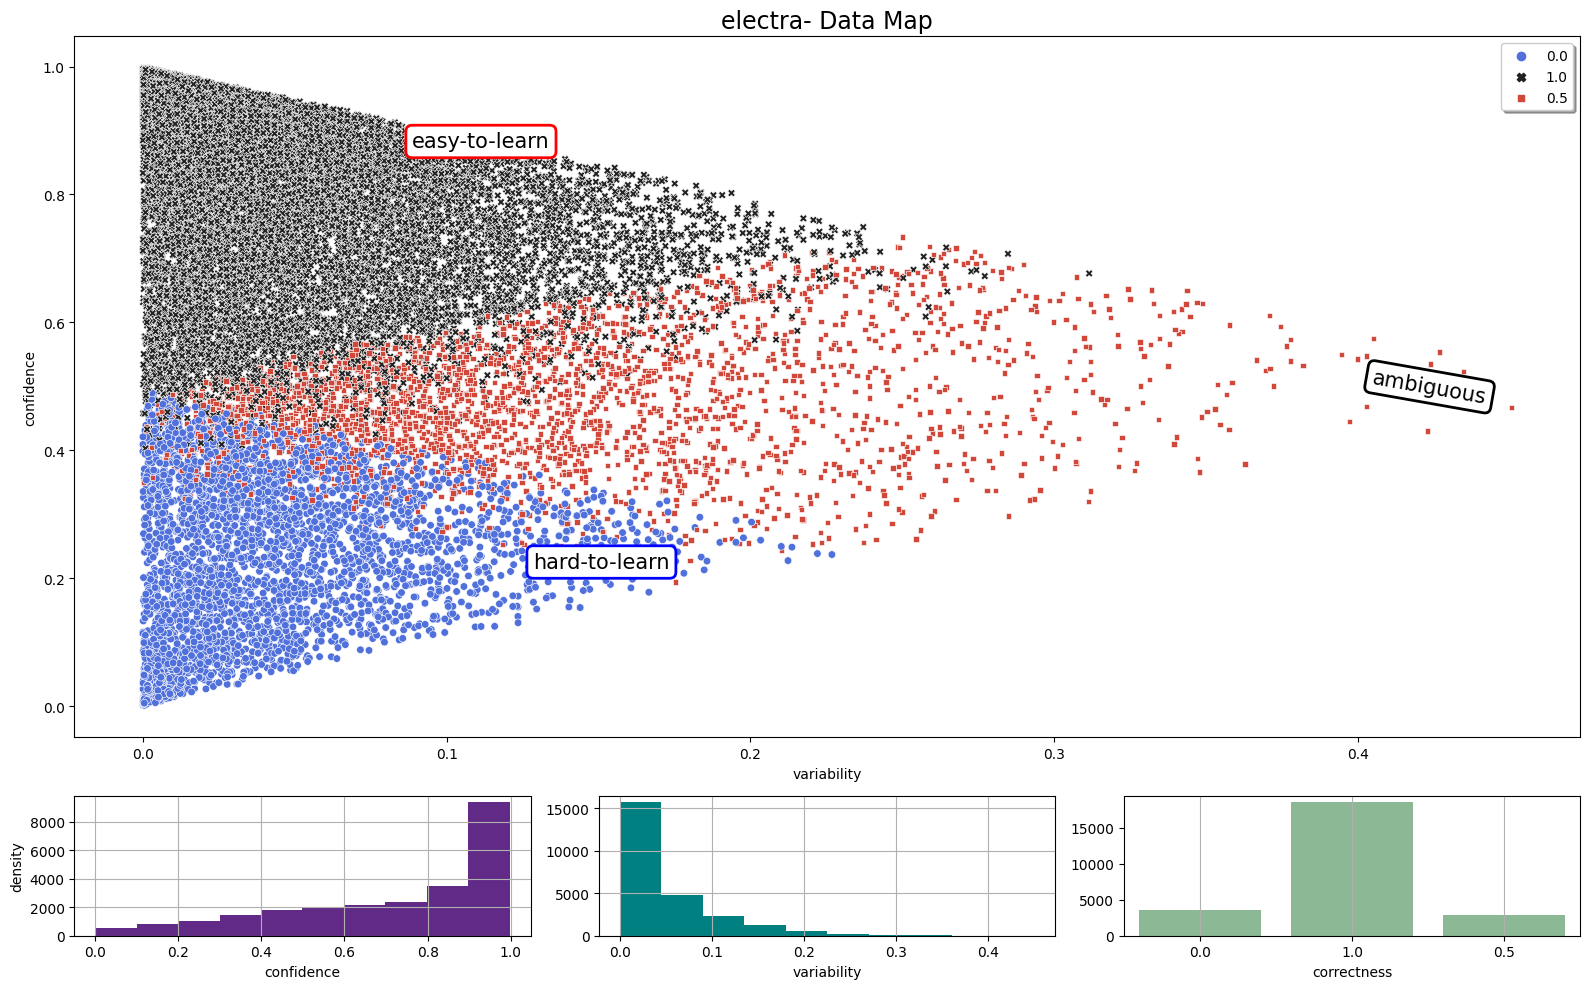

In [23]:
scatter_it(snli2, show_hist=True, model='electra hard dataset')

In [24]:
snli3, model_extra = extended_train(dataset_train['train'], epochs=2)

generating data


  0%|          | 0/550152 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

training: 0


  0%|          | 0/4299 [00:00<?, ?it/s]

{'train_runtime': 307.9698, 'train_samples_per_second': 1786.383, 'train_steps_per_second': 13.959, 'train_loss': 0.45083431466620144, 'epoch': 1.0}
recording: 0


  0%|          | 0/550152 [00:00<?, ?it/s]

training: 1


  0%|          | 0/4299 [00:00<?, ?it/s]

{'train_runtime': 312.3059, 'train_samples_per_second': 1761.581, 'train_steps_per_second': 13.765, 'train_loss': 0.3778828072753111, 'epoch': 1.0}
recording: 1


  0%|          | 0/550152 [00:00<?, ?it/s]

calculating confidence and variability


  0%|          | 0/550152 [00:00<?, ?it/s]

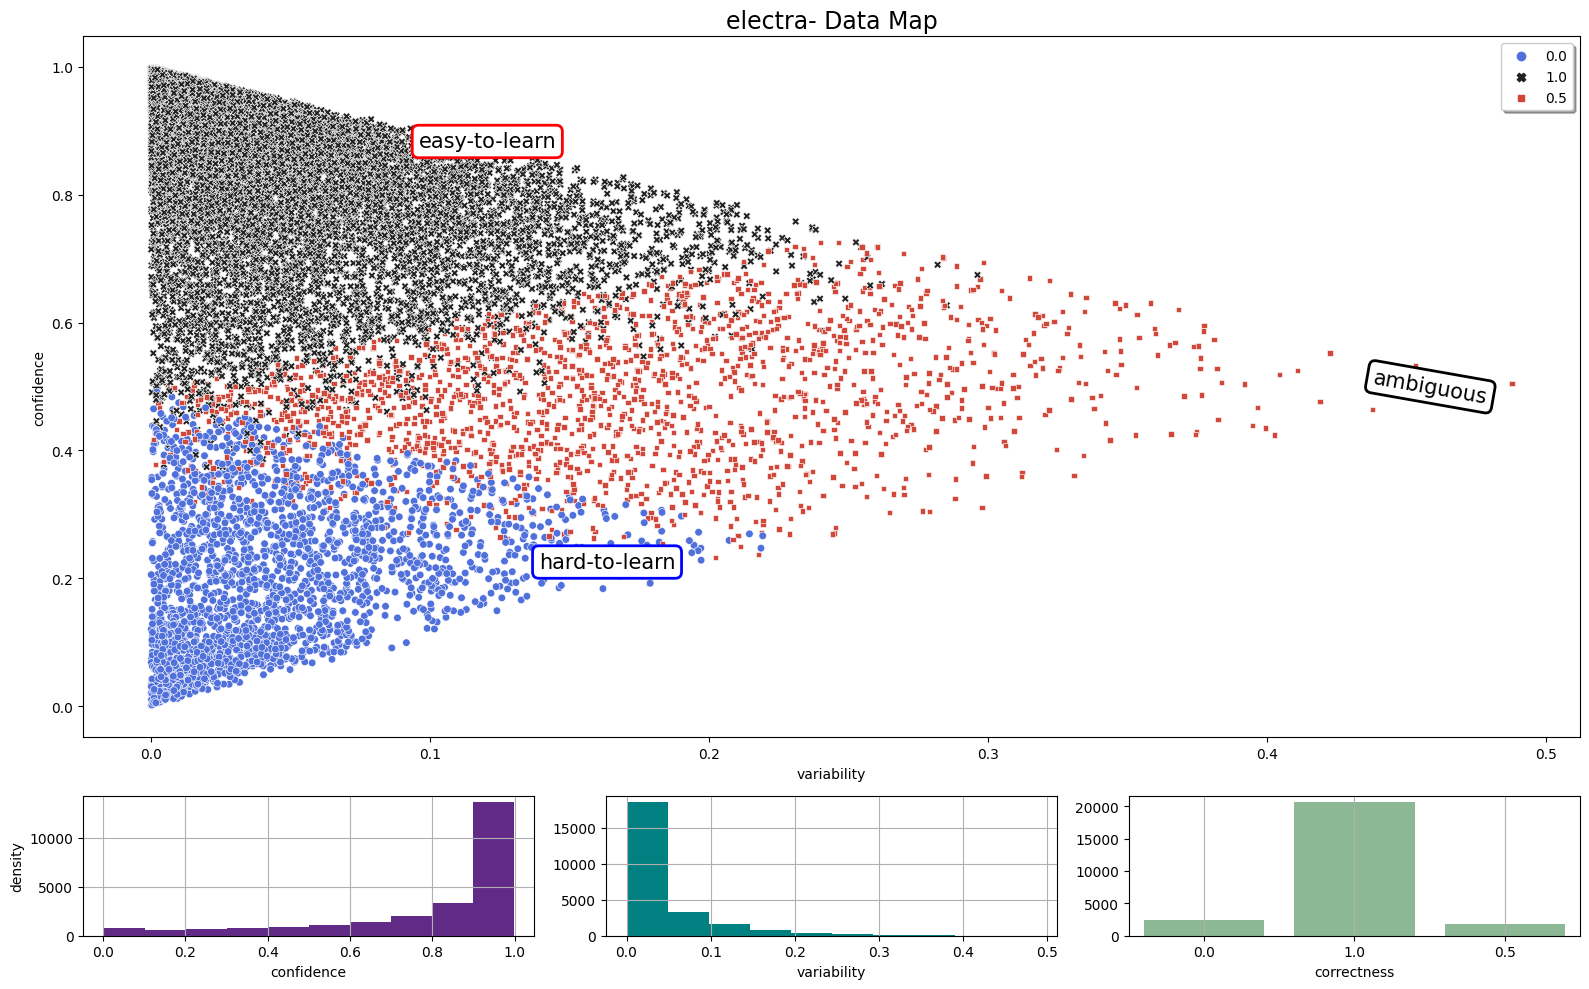

In [25]:
scatter_it(snli3, show_hist=True, model='electra full dataset')

In [26]:
print(eval(model, hard_train))
print(eval(model, dataset_train['validation']))
print()
print(eval(model_hard, hard_train))
print(eval(model_hard, dataset_train['validation']))
print()
print(eval(model_extra,hard_train ))
print(eval(model_extra, dataset_train['validation']))

  0%|          | 0/80892 [00:00<?, ?it/s]

{'eval_loss': 0.4663226008415222, 'eval_accuracy': 0.8152234554290771, 'eval_runtime': 527.3394, 'eval_samples_per_second': 1227.166, 'eval_steps_per_second': 153.396}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.32737383246421814, 'eval_accuracy': 0.8791999816894531, 'eval_runtime': 8.3706, 'eval_samples_per_second': 1194.654, 'eval_steps_per_second': 149.332}



  0%|          | 0/80892 [00:00<?, ?it/s]

{'eval_loss': 0.3910242021083832, 'eval_accuracy': 0.8390624523162842, 'eval_runtime': 540.2498, 'eval_samples_per_second': 1197.84, 'eval_steps_per_second': 149.731}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.3153632879257202, 'eval_accuracy': 0.8873999714851379, 'eval_runtime': 8.3103, 'eval_samples_per_second': 1203.323, 'eval_steps_per_second': 150.415}



  0%|          | 0/80892 [00:00<?, ?it/s]

{'eval_loss': 0.4638272225856781, 'eval_accuracy': 0.8169279098510742, 'eval_runtime': 539.2411, 'eval_samples_per_second': 1200.081, 'eval_steps_per_second': 150.011}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.31957095861434937, 'eval_accuracy': 0.8827999830245972, 'eval_runtime': 8.592, 'eval_samples_per_second': 1163.877, 'eval_steps_per_second': 145.485}


In [27]:
print(eval(model,dataset_train['test'] ))
print(eval(model_hard, dataset_train['test']))
print(eval(model_extra, dataset_train['test']))

  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.33883416652679443, 'eval_accuracy': 0.8747000098228455, 'eval_runtime': 8.4439, 'eval_samples_per_second': 1184.293, 'eval_steps_per_second': 148.037}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.33481988310813904, 'eval_accuracy': 0.8765000104904175, 'eval_runtime': 8.4876, 'eval_samples_per_second': 1178.196, 'eval_steps_per_second': 147.275}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 0.337709903717041, 'eval_accuracy': 0.8762999773025513, 'eval_runtime': 8.5064, 'eval_samples_per_second': 1175.589, 'eval_steps_per_second': 146.949}


In [55]:
snli_only_hard, model_only_hard = extended_train(only_hard_train, only_hard_data,epochs=2)

  0%|          | 0/2 [00:00<?, ?it/s]

training: 0


  0%|          | 0/758 [00:00<?, ?it/s]

{'train_runtime': 55.5212, 'train_samples_per_second': 1746.739, 'train_steps_per_second': 13.652, 'train_loss': 0.9047847536434285, 'epoch': 1.0}
recording: 0


  0%|          | 0/96981 [00:00<?, ?it/s]

training: 1


  0%|          | 0/758 [00:00<?, ?it/s]

{'train_runtime': 55.0238, 'train_samples_per_second': 1762.529, 'train_steps_per_second': 13.776, 'train_loss': 0.8397291681697312, 'epoch': 1.0}
recording: 1


  0%|          | 0/96981 [00:00<?, ?it/s]

calculating confidence and variability


  0%|          | 0/96981 [00:00<?, ?it/s]

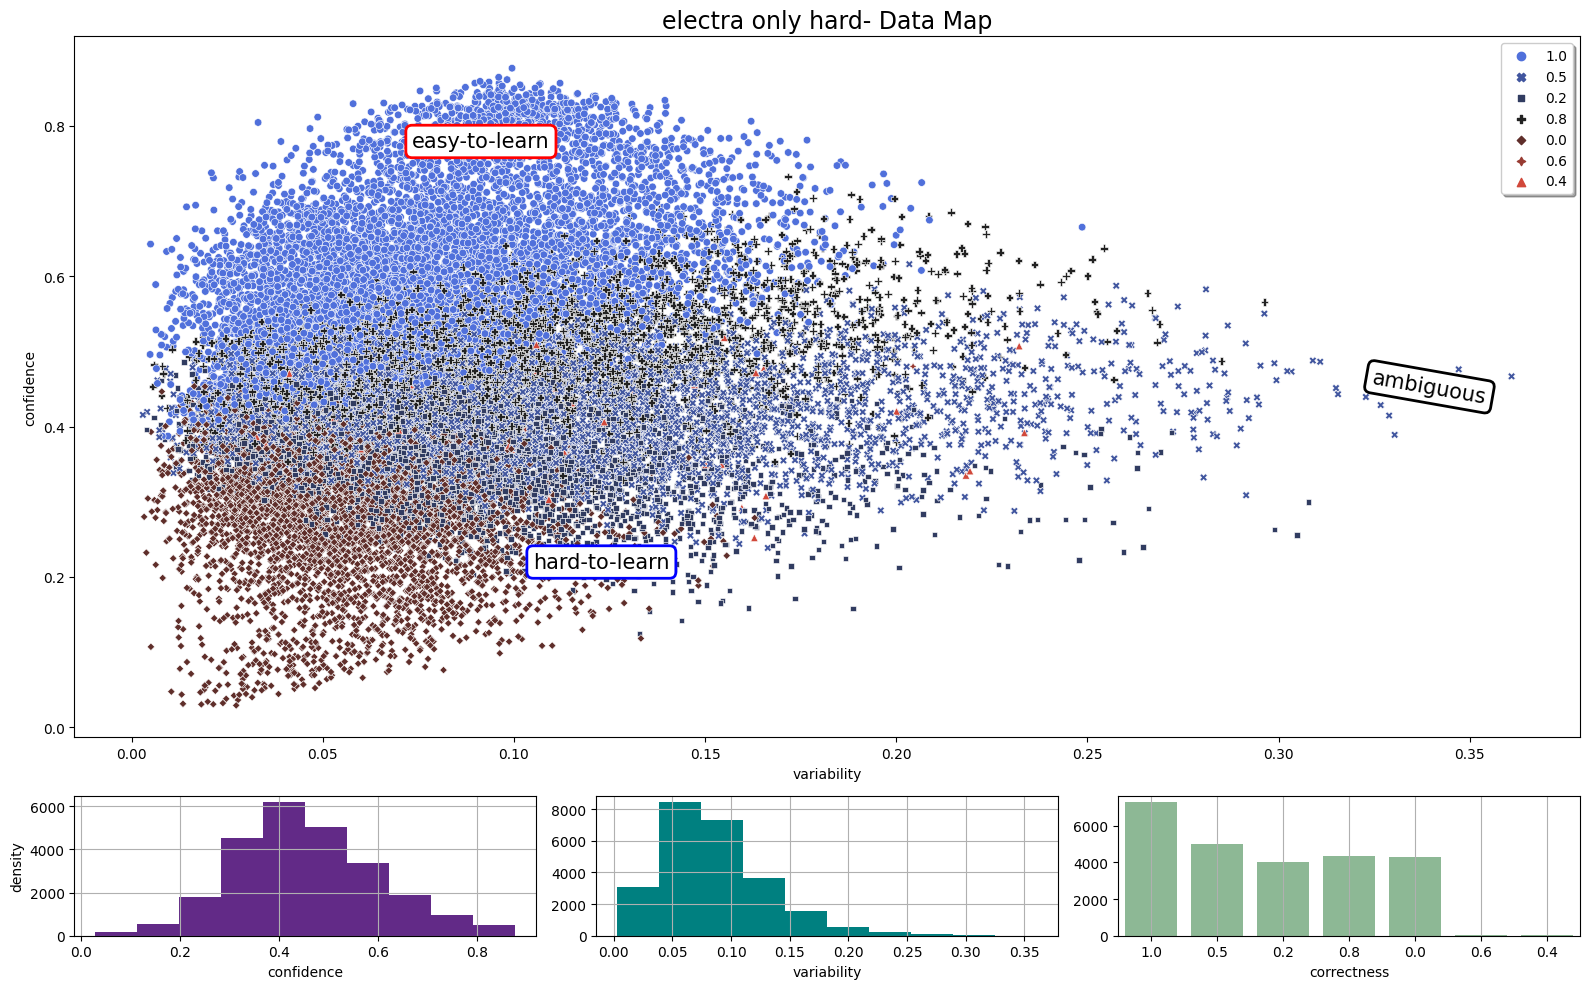

In [56]:
scatter_it(snli_only_hard, show_hist=True, model='electra only hard')


In [58]:
print(eval(model_only_hard, only_hard_train))
print(eval(model_only_hard, dataset_train['test']))
print(eval(model_only_hard, hard_train))
print(eval(model_only_hard, dataset_train['validation']))

  0%|          | 0/12123 [00:00<?, ?it/s]

{'eval_loss': 0.7415245771408081, 'eval_accuracy': 0.6382178068161011, 'eval_runtime': 82.2715, 'eval_samples_per_second': 1178.792, 'eval_steps_per_second': 147.354}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 1.7392878532409668, 'eval_accuracy': 0.25699999928474426, 'eval_runtime': 8.5188, 'eval_samples_per_second': 1173.879, 'eval_steps_per_second': 146.735}


  0%|          | 0/80892 [00:00<?, ?it/s]

{'eval_loss': 1.5719839334487915, 'eval_accuracy': 0.3266160190105438, 'eval_runtime': 544.4998, 'eval_samples_per_second': 1188.491, 'eval_steps_per_second': 148.562}


  0%|          | 0/1250 [00:00<?, ?it/s]

{'eval_loss': 1.7427327632904053, 'eval_accuracy': 0.2533000111579895, 'eval_runtime': 8.96, 'eval_samples_per_second': 1116.074, 'eval_steps_per_second': 139.509}


In [59]:
print(eval(model, only_hard_train))
print(eval(model_hard, only_hard_train))
print(eval(model_extra, only_hard_train))

  0%|          | 0/12123 [00:00<?, ?it/s]

{'eval_loss': 1.3809545040130615, 'eval_accuracy': 0.3995112478733063, 'eval_runtime': 83.1943, 'eval_samples_per_second': 1165.717, 'eval_steps_per_second': 145.719}


  0%|          | 0/12123 [00:00<?, ?it/s]

{'eval_loss': 1.0425019264221191, 'eval_accuracy': 0.49973705410957336, 'eval_runtime': 81.2644, 'eval_samples_per_second': 1193.401, 'eval_steps_per_second': 149.18}


  0%|          | 0/12123 [00:00<?, ?it/s]

{'eval_loss': 1.3678147792816162, 'eval_accuracy': 0.4096575677394867, 'eval_runtime': 80.2624, 'eval_samples_per_second': 1208.3, 'eval_steps_per_second': 151.042}
